<a href="https://colab.research.google.com/github/felicityogoke/HealthCare-Sentiment-Analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Collection


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# # Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


##Exploratory Analysis

In [ ]:
# Load Tweet dataset# Load dataset file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/webmd.csv")
# Output first five rows
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [ ]:
# Map the numerical ratings to corresponding labels
label_map = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df['sentiment'] = df['Satisfaction'].map(label_map)

In [ ]:
# create a new dataframe with only the reviews column and sentiment column
df = df.loc[:, ['Reviews', 'sentiment']]

In [ ]:
df.head()

,Reviews,sentiment
0,I'm a retired physician and of all the meds I ...,Positive
1,cleared me right up even with my throat hurtin...,Positive
2,why did my PTINR go from a normal of 2.5 to ov...,Neutral
3,FALLING AND DON'T REALISE IT,Negative
4,My grandfather was prescribed this medication ...,Negative


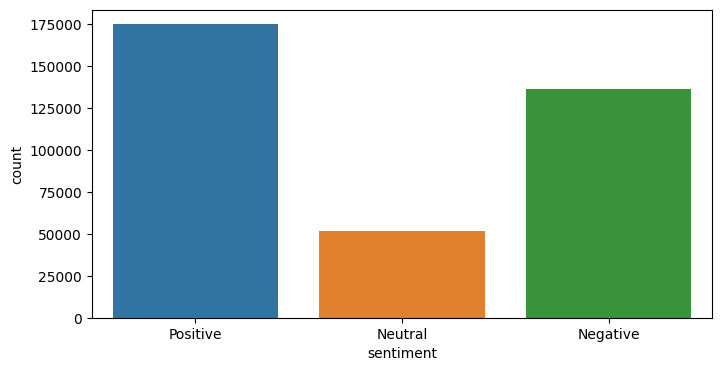

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df);

In [ ]:
# Drop all rows with a rating of 3
df = df.loc[df['sentiment'] != 'Neutral']


In [ ]:
df['Reviews'].apply(lambda x:len(str(x).split())).max()

534

In [ ]:
#print the number of null values in each column
df.isnull().sum()

Reviews      31
sentiment     3
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
# Split the data into training and testing sets (70% for training and 30% for testing)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Split the training data into training and validation sets (50% for training and 50% for validation)
df_train, df_val = train_test_split(df_train, test_size=0.5, random_state=42)


In [ ]:
df_train.shape

(108822, 2)

In [ ]:
df_val.shape

(108822, 2)

In [ ]:
df_test.shape

(93276, 2)

In [ ]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Reviews'].duplicated() == True]

,Reviews,sentiment
14,,Negative
877,good,Positive
2582,not good,Positive
6218,cough,Positive
7762,\n,Negative
11209,dizziness,Negative
12181,muscle pain,Positive
12486,still pain,Positive
14347,none,Positive
16779,back pain,Negative


In [ ]:
#print some of those rows to check
df_train[df_train['Reviews'] == df_train.iloc[33083]['Reviews']]

,Reviews,sentiment
26806,dry mouth,Negative
33083,dry mouth,Positive


In [ ]:
#removing duplicated text 
index = df_train[df_train['Reviews'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
df_train.shape

(87094, 2)

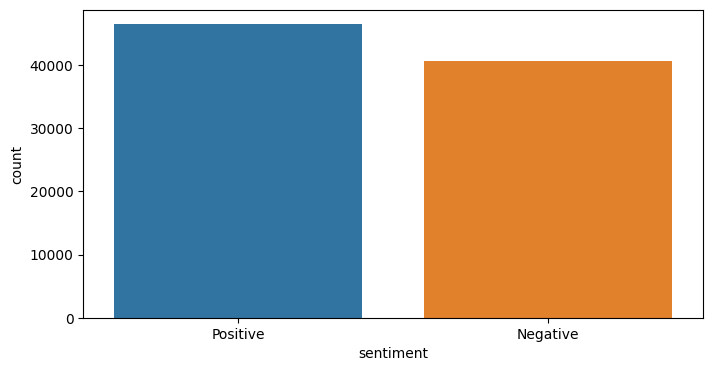

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_train);

In [ ]:
df_train = df_train.loc[:12000,:]
df_train.shape

(12001, 2)

In [ ]:
#We will check the maximum number of words that can be present in a comment , this will help us in padding later
df_train['Reviews'].apply(lambda x:len(str(x).split())).max()

422

In [ ]:
#a function for getting auc score for validation

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df_train.Reviews.values, df_train.sentiment.values, 
                                                  stratify=df_train.sentiment.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [ ]:
le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
yvalid = le.fit_transform(yvalid)

In [ ]:
print(ytrain)

[0 1 1 ... 1 1 0]


In [ ]:
xtrain.shape, ytrain.shape

((9600,), (9600,))

##SIMPLE RNN

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
%%time
    # A simpleRNN without any pretrained embeddings and one dense layer
rnn_model = Sequential()
rnn_model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
rnn_model.add(SimpleRNN(100))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          6336000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6,376,201
Trainable params: 6,376,201
Non-trainable params: 0
_________________________________________________________________
CPU times: user 227 ms, sys: 15.1 ms, total: 242 ms
Wall time: 393 ms


In [ ]:
rnn_model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64) 

Epoch 1/5
150/150 [==============================] - 96s 606ms/step - loss: 0.6614 - accuracy: 0.5832
Epoch 2/5
150/150 [==============================] - 81s 539ms/step - loss: 0.3635 - accuracy: 0.8378
Epoch 3/5
150/150 [==============================] - 72s 483ms/step - loss: 0.1086 - accuracy: 0.9623
Epoch 4/5
150/150 [==============================] - 68s 451ms/step - loss: 0.0334 - accuracy: 0.9894
Epoch 5/5
150/150 [==============================] - 68s 453ms/step - loss: 0.0127 - accuracy: 0.9966


In [ ]:
scores_rnn = rnn_model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_rnn,yvalid)))

76/76 [==============================] - 3s 40ms/step
Auc: 0.79%


In [ ]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores_rnn,yvalid)})

##LSTM MODEL


In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/drive/MyDrive/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:26, 10620.62it/s]

Found 2196016 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 21119/21119 [00:00<00:00, 284095.34it/s]


In [ ]:
%%time

    
# A simple LSTM with glove embeddings and one dense layer
lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

lstm_model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          6336000   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,496,501
Trainable params: 160,501
Non-trainable params: 6,336,000
_________________________________________________________________
CPU times: user 214 ms, sys: 49.3 ms, total: 263 ms
Wall time: 274 ms


In [ ]:
lstm_model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)

Epoch 1/5
150/150 [==============================] - 127s 829ms/step - loss: 0.6119 - accuracy: 0.6596
Epoch 2/5
150/150 [==============================] - 123s 819ms/step - loss: 0.5557 - accuracy: 0.7179
Epoch 3/5
150/150 [==============================] - 124s 828ms/step - loss: 0.5209 - accuracy: 0.7408
Epoch 4/5
150/150 [==============================] - 123s 819ms/step - loss: 0.4876 - accuracy: 0.7624
Epoch 5/5
150/150 [==============================] - 123s 816ms/step - loss: 0.4626 - accuracy: 0.7843


In [ ]:
scores_lstm = lstm_model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_lstm,yvalid)))

76/76 [==============================] - 12s 151ms/step
Auc: 0.87%


In [ ]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores_lstm,yvalid)})

##GRU 

In [ ]:
%%time

# GRU with glove embeddings and two dense layers
gru_model = Sequential()
gru_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
gru_model.add(SpatialDropout1D(0.3))
gru_model.add(GRU(300))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 300)          6336000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 300)         0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               541800    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 6,878,101
Trainable params: 542,101
Non-trainable params: 6,336,000
_________________________________________________________________
CPU times: user 302 ms, sys: 55.6 ms, total: 357 ms
Wall time: 365 ms


In [ ]:
gru_model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)

Epoch 1/5
150/150 [==============================] - 11s 57ms/step - loss: 0.6463 - accuracy: 0.6247
Epoch 2/5
150/150 [==============================] - 9s 58ms/step - loss: 0.5428 - accuracy: 0.7259
Epoch 3/5
150/150 [==============================] - 9s 58ms/step - loss: 0.4819 - accuracy: 0.7610
Epoch 4/5
150/150 [==============================] - 8s 56ms/step - loss: 0.4474 - accuracy: 0.7881
Epoch 5/5
150/150 [==============================] - 8s 56ms/step - loss: 0.4162 - accuracy: 0.8047


In [ ]:
scores_gru = gru_model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_gru,yvalid)))

76/76 [==============================] - 2s 14ms/step
Auc: 0.88%


In [ ]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores_gru,yvalid)})

##Bidirectional LSTM

In [ ]:
    # A simple bidirectional LSTM with glove embeddings and one dense layer
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
bi_lstm_model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

bi_lstm_model.add(Dense(1,activation='sigmoid'))
bi_lstm_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
bi_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 300)          6336000   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 601       
                                                                 
Total params: 7,779,001
Trainable params: 1,443,001
Non-trainable params: 6,336,000
_________________________________________________________________


In [ ]:
bi_lstm_model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)

Epoch 1/5
150/150 [==============================] - 228s 1s/step - loss: 0.6227 - accuracy: 0.6459
Epoch 2/5
150/150 [==============================] - 225s 1s/step - loss: 0.5824 - accuracy: 0.6989
Epoch 3/5
150/150 [==============================] - 223s 1s/step - loss: 0.5383 - accuracy: 0.7287
Epoch 4/5
150/150 [==============================] - 223s 1s/step - loss: 0.5064 - accuracy: 0.7536
Epoch 5/5
150/150 [==============================] - 231s 2s/step - loss: 0.4566 - accuracy: 0.7804


In [ ]:
scores_bi_lstm = bi_lstm_model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_bi_lstm,yvalid)))

76/76 [==============================] - 25s 319ms/step
Auc: 0.86%


In [ ]:
scores_model.append({'Model': 'Bi-directional LSTM','AUC_Score': roc_auc(scores_bi_lstm,yvalid)})

In [ ]:
scores_model

[{'Model': 'SimpleRNN', 'AUC_Score': 0.789736708528909},
 {'Model': 'LSTM', 'AUC_Score': 0.865791910351771},
 {'Model': 'GRU', 'AUC_Score': 0.8756773678940866},
 {'Model': 'Bi-directional LSTM', 'AUC_Score': 0.8623775299324793}]